In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-722.jpg
/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-537.jpg
/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-115.jpg
/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-777.jpg
/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-058.jpg
/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-655.jpg
/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-097.jpg
/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-649.jpg
/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-663.jpg
/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-352.jpg
/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-373.jpg
/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-685.jpg
/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-256.jpg
/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-686.jpg
/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-442.jpg
/kaggle/input/leukemia/Segmented/Pro/WBC-Malignant-Pro-

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class LeukemiaSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, sample_list):
        self.images = []
        self.masks = []
        for cls, fname in sample_list:
            self.images.append(os.path.join(images_dir, cls, fname))
            self.masks.append(os.path.join(masks_dir, cls, fname))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB").resize((224, 224))
        mask = Image.open(self.masks[idx]).convert("L").resize((224, 224))
        image = np.array(image) / 255.0
        mask = np.array(mask) / 255.0
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # CHW
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)       # 1CHW
        return image, mask

In [4]:
root = '/kaggle/input/leukemia'  # Your dataset root path
classes = ['Benign', 'Early', 'Pre', 'Pro']
img_dir = os.path.join(root, 'Original')
mask_dir = os.path.join(root, 'Segmented')

# Prepare (class, filename) pairs where image and mask both exist
sample_list = []
for cls in classes:
    imgs = set(os.listdir(os.path.join(img_dir, cls)))
    masks = set(os.listdir(os.path.join(mask_dir, cls)))
    files = sorted(list(imgs & masks))
    sample_list.extend([(cls, fname) for fname in files])

all_idx = np.arange(len(sample_list))
trainval_idx, test_idx = train_test_split(all_idx, test_size=0.15, random_state=42)
train_idx, val_idx = train_test_split(trainval_idx, test_size=0.15, random_state=42)

In [5]:
from sklearn.model_selection import train_test_split

trainval, test = train_test_split(sample_list, test_size=0.15, random_state=42)
train, val     = train_test_split(trainval, test_size=0.15, random_state=42)

# Create datasets
train_ds = LeukemiaSegmentationDataset(img_dir, mask_dir, train)
val_ds   = LeukemiaSegmentationDataset(img_dir, mask_dir, val)
test_ds  = LeukemiaSegmentationDataset(img_dir, mask_dir, test)

batch_size = 8
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [6]:
def get_model(encoder_name):
    return smp.Unet(
        encoder_name=encoder_name,
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    )


In [7]:
!pip install segmentation_models_pytorch


=== Training UNet Experiment 1 with {'optimizer': 'Adam', 'lr': 0.001, 'weight_decay': 0.0001} ===
Epoch 1/5 - Train Loss: 0.1154 - Val Loss: 0.1020
Epoch 2/5 - Train Loss: 0.0854 - Val Loss: 0.0879
Epoch 3/5 - Train Loss: 0.0832 - Val Loss: 0.1361
Epoch 4/5 - Train Loss: 0.0826 - Val Loss: 0.2441
Epoch 5/5 - Train Loss: 0.0822 - Val Loss: 0.1053


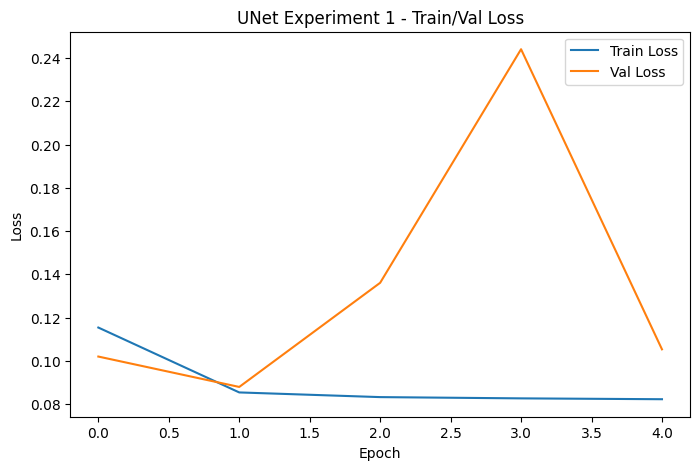

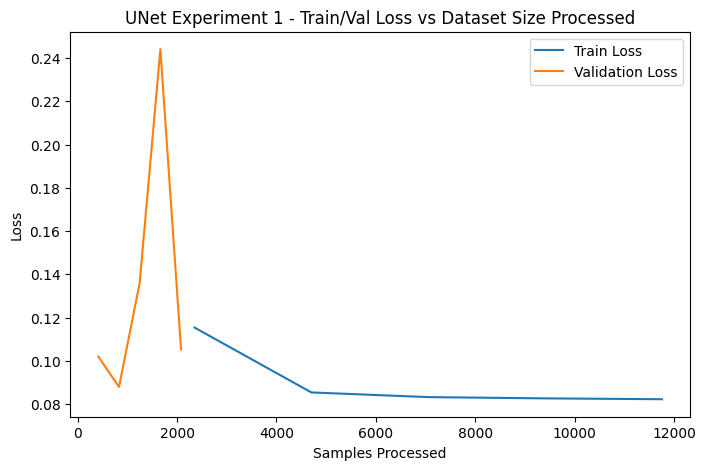

Saved model: unet_exp1_Adam_lr0.001_wd0.0001.pth

=== Training UNet Experiment 2 with {'optimizer': 'SGD', 'lr': 0.01, 'weight_decay': 0.001} ===
Epoch 1/5 - Train Loss: 0.1187 - Val Loss: 0.0970
Epoch 2/5 - Train Loss: 0.0911 - Val Loss: 0.0920
Epoch 3/5 - Train Loss: 0.0881 - Val Loss: 0.0903
Epoch 4/5 - Train Loss: 0.0866 - Val Loss: 0.0896
Epoch 5/5 - Train Loss: 0.0857 - Val Loss: 0.0884


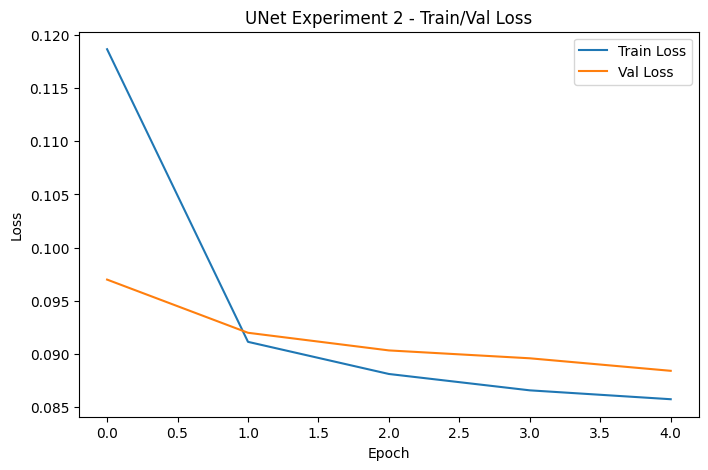

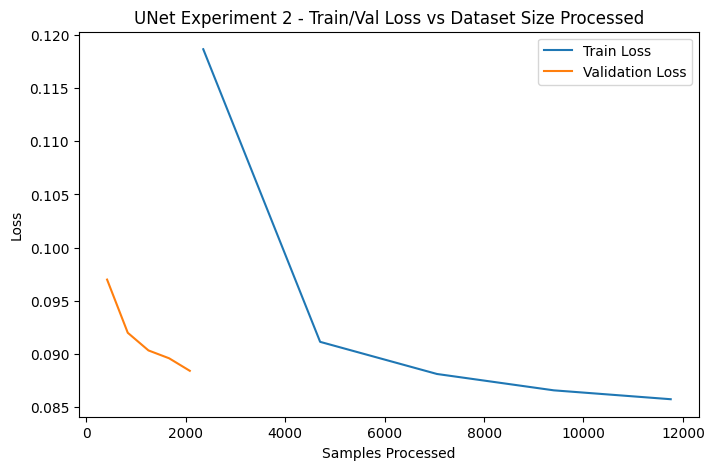

Saved model: unet_exp2_SGD_lr0.01_wd0.001.pth

=== Training UNet Experiment 3 with {'optimizer': 'RMSprop', 'lr': 0.0001, 'weight_decay': 0} ===
Epoch 1/5 - Train Loss: 0.2408 - Val Loss: 0.1503
Epoch 2/5 - Train Loss: 0.1249 - Val Loss: 0.1064
Epoch 3/5 - Train Loss: 0.0965 - Val Loss: 0.0919
Epoch 4/5 - Train Loss: 0.0869 - Val Loss: 0.0881
Epoch 5/5 - Train Loss: 0.0839 - Val Loss: 0.0863


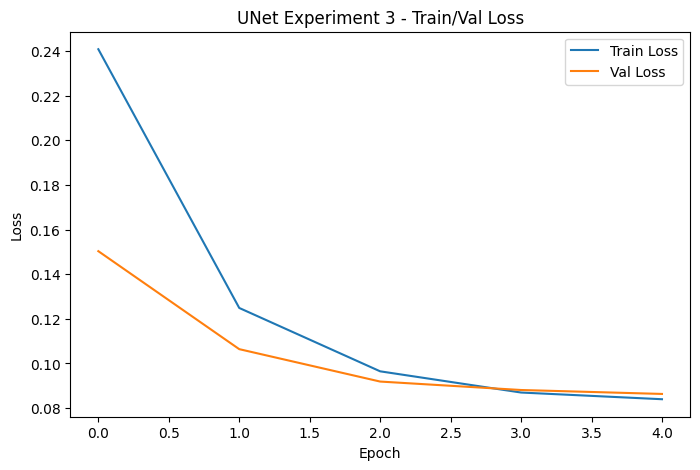

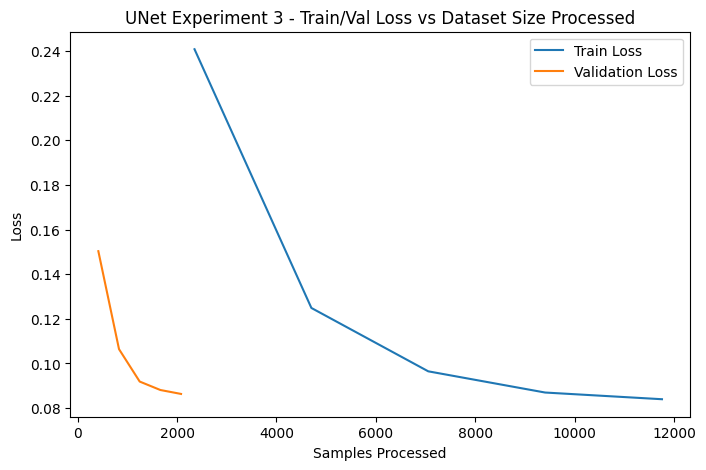

Saved model: unet_exp3_RMSprop_lr0.0001_wd0.pth

=== Evaluating on Test Set ===

--- Confusion Matrix for UNet Experiment 1 ---


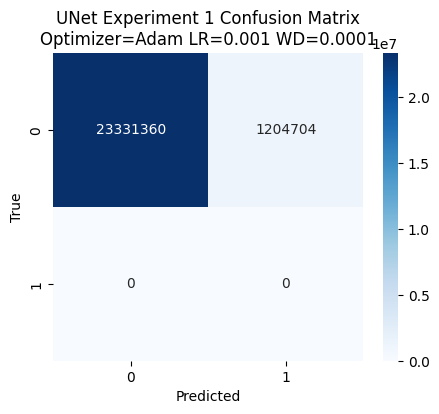


--- Confusion Matrix for UNet Experiment 2 ---


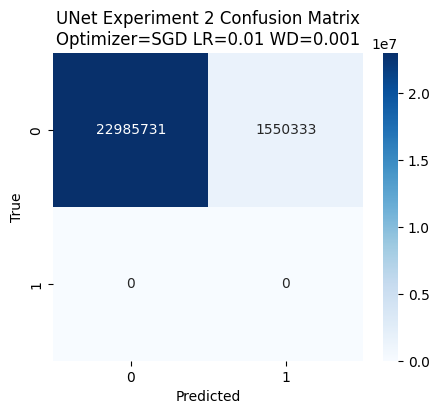


--- Confusion Matrix for UNet Experiment 3 ---


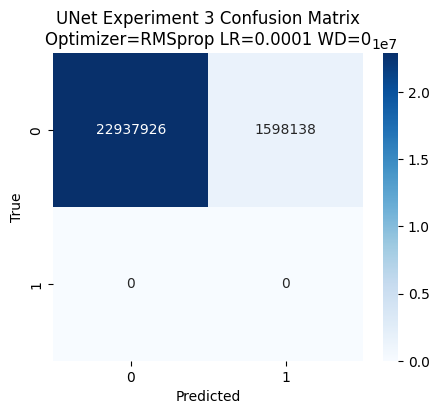

In [8]:
import segmentation_models_pytorch as smp
def get_model():
    return smp.Unet(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    ).to(device)

def get_optimizer(name, params, lr, wd):
    if name == 'Adam':
        return torch.optim.Adam(params, lr=lr, weight_decay=wd)
    elif name == 'SGD':
        return torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    elif name == 'RMSprop':
        return torch.optim.RMSprop(params, lr=lr, weight_decay=wd)
    else:
        raise ValueError(f"Unknown optimizer {name}")

unet_hyperparams = [
    {'optimizer': 'Adam',    'lr': 1e-3, 'weight_decay': 1e-4},
    {'optimizer': 'SGD',     'lr': 1e-2, 'weight_decay': 1e-3},
    {'optimizer': 'RMSprop', 'lr': 1e-4, 'weight_decay': 0}
]

epochs = 5
criterion = nn.BCEWithLogitsLoss()

trained_models = []

for i, hp in enumerate(unet_hyperparams, 1):
    print(f"\n=== Training UNet Experiment {i} with {hp} ===")
    model = get_model()
    optimizer = get_optimizer(hp['optimizer'], model.parameters(), hp['lr'], hp['weight_decay'])

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            preds = model(imgs)
            loss = criterion(preds, masks)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * imgs.size(0)
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)
                loss = criterion(preds, masks)
                total_val_loss += loss.item() * imgs.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f"UNet Experiment {i} - Train/Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    train_data_size = len(train_ds)
    val_data_size = len(val_ds)
    epochs_range = range(1, epochs + 1)
    train_samples_processed = [epoch * train_data_size for epoch in epochs_range]
    val_samples_processed = [epoch * val_data_size for epoch in epochs_range]

    plt.figure(figsize=(8,5))
    plt.plot(train_samples_processed, train_losses, label='Train Loss')
    plt.plot(val_samples_processed, val_losses, label='Validation Loss')
    plt.xlabel('Samples Processed')
    plt.ylabel('Loss')
    plt.title(f"UNet Experiment {i} - Train/Val Loss vs Dataset Size Processed")
    plt.legend()
    plt.show()

    model_path = f"unet_exp{i}_{hp['optimizer']}_lr{hp['lr']}_wd{hp['weight_decay']}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    trained_models.append((model, hp, model_path))

print("\n=== Evaluating on Test Set ===")
for i, (model, hp, model_path) in enumerate(trained_models, 1):
    print(f"\n--- Confusion Matrix for UNet Experiment {i} ---")
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            masks = masks.numpy().astype(int)
            all_preds.append(preds.flatten())
            all_targets.append(masks.flatten())
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    cm = confusion_matrix(all_targets, all_preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"UNet Experiment {i} Confusion Matrix\nOptimizer={hp['optimizer']} LR={hp['lr']} WD={hp['weight_decay']}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


=== Training FPN Experiment 1 with {'optimizer': 'Adam', 'lr': 0.01, 'weight_decay': 0.001} ===
Epoch 1/5 - Train Loss: 0.1482 - Val Loss: 0.1686
Epoch 2/5 - Train Loss: 0.1025 - Val Loss: 0.1919
Epoch 3/5 - Train Loss: 0.1007 - Val Loss: 0.1272
Epoch 4/5 - Train Loss: 0.0993 - Val Loss: 0.1541
Epoch 5/5 - Train Loss: 0.0996 - Val Loss: 0.1028


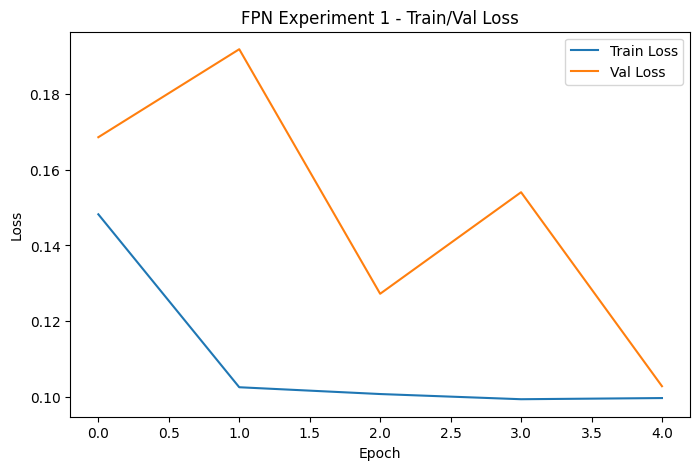

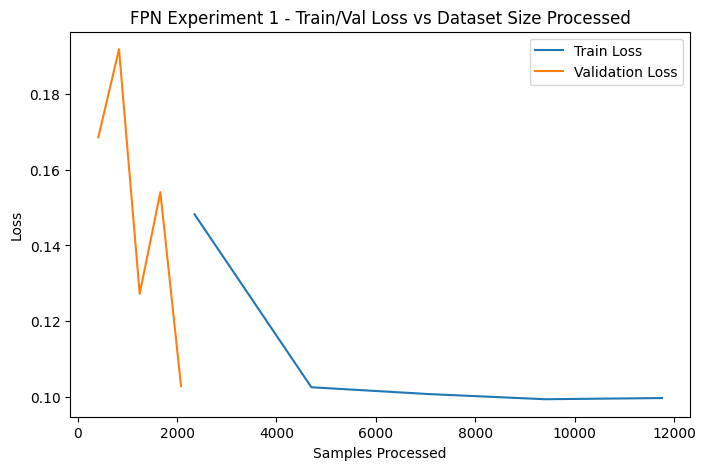

Saved model: fpn_exp1_Adam_lr0.01_wd0.001.pth

=== Training FPN Experiment 2 with {'optimizer': 'SGD', 'lr': 0.001, 'weight_decay': 0.0001} ===
Epoch 1/5 - Train Loss: 0.2147 - Val Loss: 0.1322
Epoch 2/5 - Train Loss: 0.1398 - Val Loss: 0.1215
Epoch 3/5 - Train Loss: 0.1269 - Val Loss: 0.1152
Epoch 4/5 - Train Loss: 0.1214 - Val Loss: 0.1125
Epoch 5/5 - Train Loss: 0.1162 - Val Loss: 0.1100


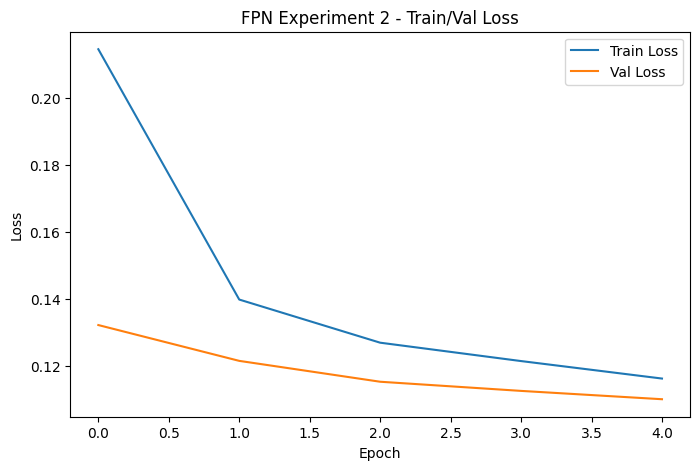

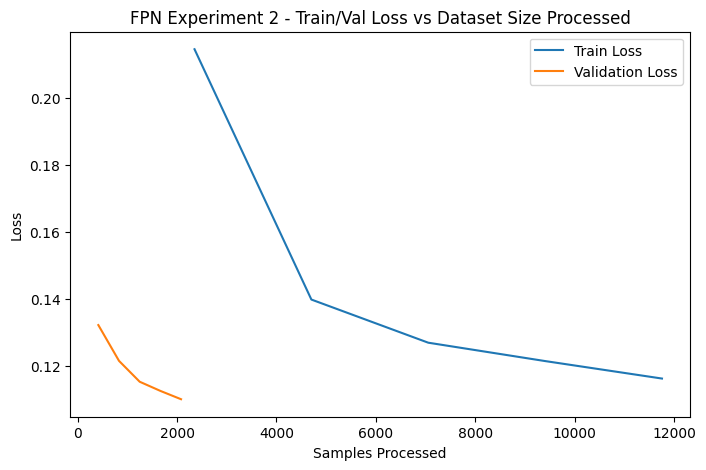

Saved model: fpn_exp2_SGD_lr0.001_wd0.0001.pth

=== Training FPN Experiment 3 with {'optimizer': 'RMSprop', 'lr': 0.0001, 'weight_decay': 0} ===
Epoch 1/5 - Train Loss: 0.1326 - Val Loss: 0.1019
Epoch 2/5 - Train Loss: 0.0990 - Val Loss: 0.0984
Epoch 3/5 - Train Loss: 0.0941 - Val Loss: 0.1113
Epoch 4/5 - Train Loss: 0.0915 - Val Loss: 0.0934
Epoch 5/5 - Train Loss: 0.0897 - Val Loss: 0.0921


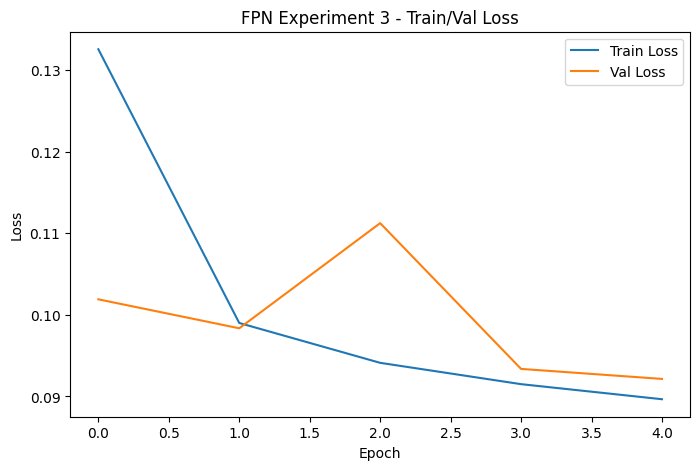

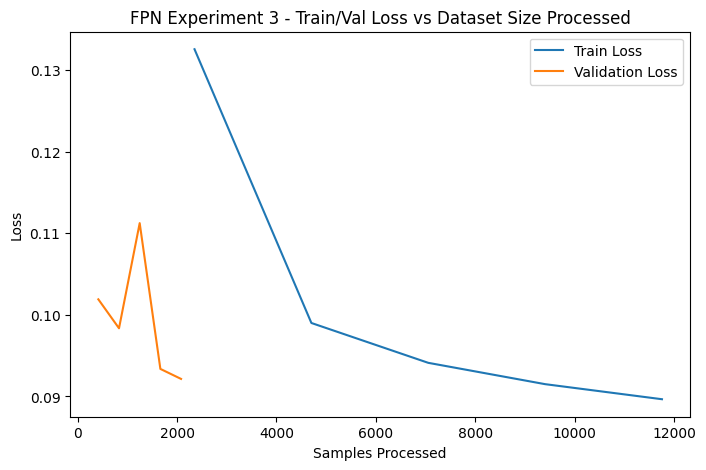

Saved model: fpn_exp3_RMSprop_lr0.0001_wd0.pth

=== Evaluating on Test Set ===

--- Confusion Matrix for FPN Experiment 1 ---


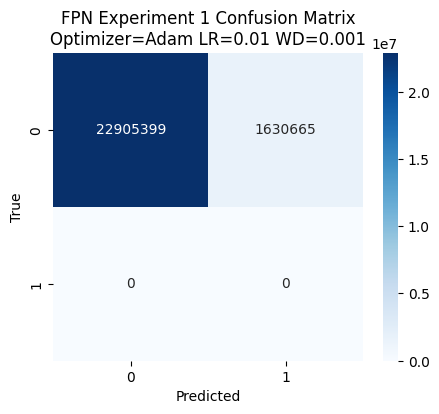


--- Confusion Matrix for FPN Experiment 2 ---


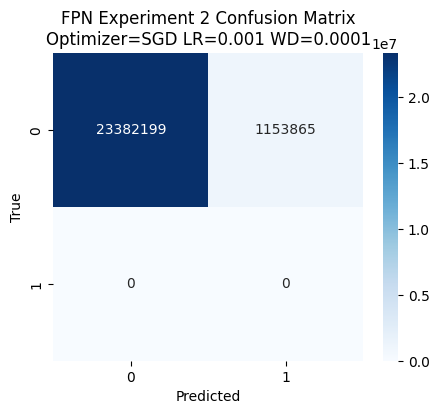


--- Confusion Matrix for FPN Experiment 3 ---


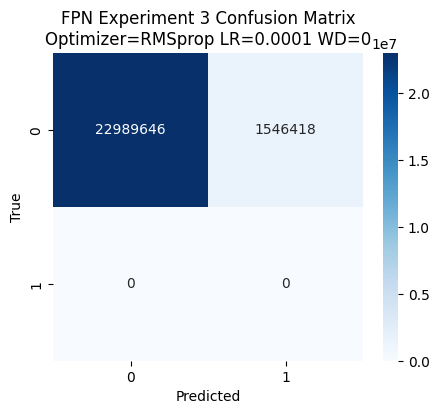

In [9]:
def get_model():
    return smp.FPN(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    ).to(device)

def get_optimizer(name, params, lr, wd):
    if name == 'Adam':
        return torch.optim.Adam(params, lr=lr, weight_decay=wd)
    elif name == 'SGD':
        return torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    elif name == 'RMSprop':
        return torch.optim.RMSprop(params, lr=lr, weight_decay=wd)
    else:
        raise ValueError(f"Unknown optimizer {name}")

fpn_hyperparams = [
    {'optimizer': 'Adam',    'lr': 1e-2, 'weight_decay': 1e-3},
    {'optimizer': 'SGD',     'lr': 1e-3, 'weight_decay': 1e-4},
    {'optimizer': 'RMSprop', 'lr': 1e-4, 'weight_decay': 0}
]

epochs = 5
criterion = nn.BCEWithLogitsLoss()

trained_models = []

for i, hp in enumerate(fpn_hyperparams, 1):
    print(f"\n=== Training FPN Experiment {i} with {hp} ===")
    model = get_model()
    optimizer = get_optimizer(hp['optimizer'], model.parameters(), hp['lr'], hp['weight_decay'])

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            preds = model(imgs)
            loss = criterion(preds, masks)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * imgs.size(0)
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)
                loss = criterion(preds, masks)
                total_val_loss += loss.item() * imgs.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f"FPN Experiment {i} - Train/Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    train_data_size = len(train_ds)
    val_data_size = len(val_ds)
    epochs_range = range(1, epochs + 1)
    train_samples_processed = [epoch * train_data_size for epoch in epochs_range]
    val_samples_processed = [epoch * val_data_size for epoch in epochs_range]

    plt.figure(figsize=(8,5))
    plt.plot(train_samples_processed, train_losses, label='Train Loss')
    plt.plot(val_samples_processed, val_losses, label='Validation Loss')
    plt.xlabel('Samples Processed')
    plt.ylabel('Loss')
    plt.title(f"FPN Experiment {i} - Train/Val Loss vs Dataset Size Processed")
    plt.legend()
    plt.show()+

    model_path = f"fpn_exp{i}_{hp['optimizer']}_lr{hp['lr']}_wd{hp['weight_decay']}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    trained_models.append((model, hp, model_path))

print("\n=== Evaluating on Test Set ===")
for i, (model, hp, model_path) in enumerate(trained_models, 1):
    print(f"\n--- Confusion Matrix for FPN Experiment {i} ---")
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            masks = masks.numpy().astype(int)
            all_preds.append(preds.flatten())
            all_targets.append(masks.flatten())
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    cm = confusion_matrix(all_targets, all_preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"FPN Experiment {i} Confusion Matrix\nOptimizer={hp['optimizer']} LR={hp['lr']} WD={hp['weight_decay']}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



=== Training DeepLabV3 Experiment 1 with {'optimizer': 'Adam', 'lr': 0.0001, 'weight_decay': 0.0001} ===
Epoch 1/5 - Train Loss: 0.2116 - Val Loss: 0.1342
Epoch 2/5 - Train Loss: 0.1201 - Val Loss: 0.1241
Epoch 3/5 - Train Loss: 0.1064 - Val Loss: 0.1089
Epoch 4/5 - Train Loss: 0.1009 - Val Loss: 0.1101
Epoch 5/5 - Train Loss: 0.0981 - Val Loss: 0.1014


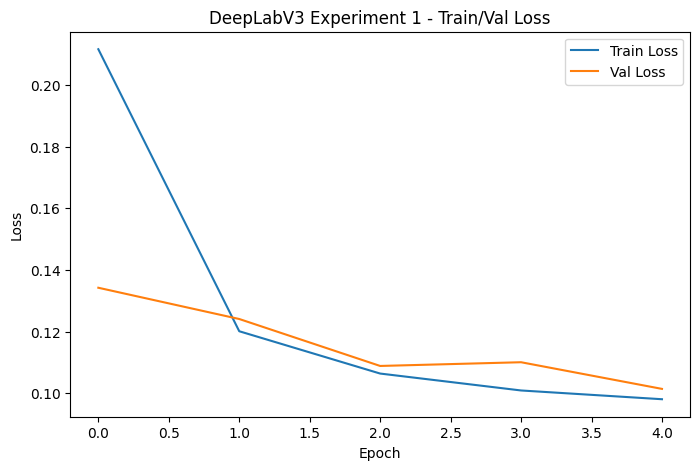

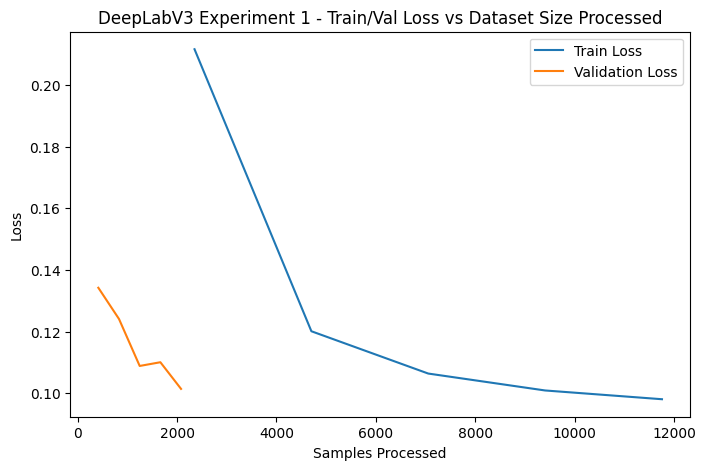

Saved model: deeplabv3_exp1_Adam_lr0.0001_wd0.0001.pth

=== Training DeepLabV3 Experiment 2 with {'optimizer': 'SGD', 'lr': 0.01, 'weight_decay': 0.001} ===
Epoch 1/5 - Train Loss: 0.1388 - Val Loss: 0.1378
Epoch 2/5 - Train Loss: 0.1080 - Val Loss: 0.1196
Epoch 3/5 - Train Loss: 0.1038 - Val Loss: 0.1205
Epoch 4/5 - Train Loss: 0.1017 - Val Loss: 0.1137
Epoch 5/5 - Train Loss: 0.1007 - Val Loss: 0.1115


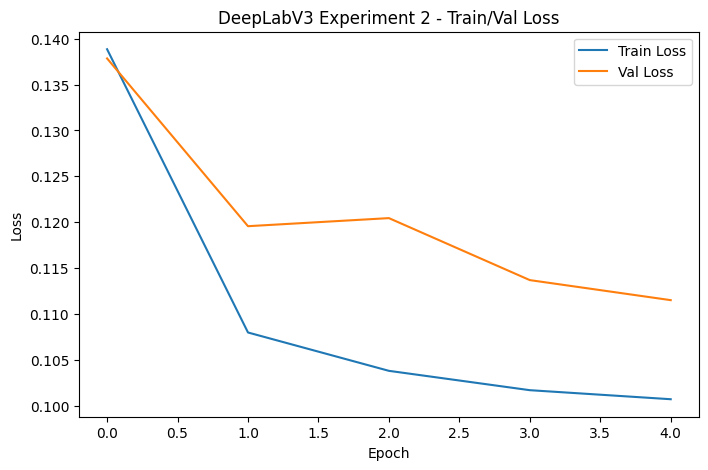

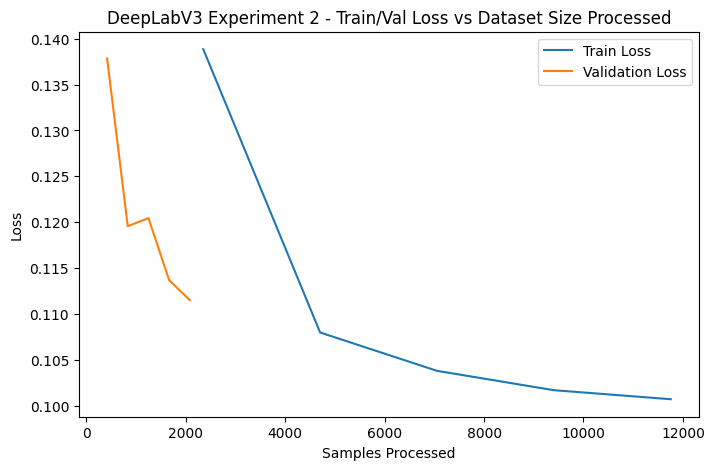

Saved model: deeplabv3_exp2_SGD_lr0.01_wd0.001.pth

=== Training DeepLabV3 Experiment 3 with {'optimizer': 'RMSprop', 'lr': 0.001, 'weight_decay': 0.0001} ===
Epoch 1/5 - Train Loss: 0.1285 - Val Loss: 10.1958
Epoch 2/5 - Train Loss: 0.1072 - Val Loss: 3.6445
Epoch 3/5 - Train Loss: 0.1035 - Val Loss: 0.1246
Epoch 4/5 - Train Loss: 0.1005 - Val Loss: 0.1031
Epoch 5/5 - Train Loss: 0.0994 - Val Loss: 0.1075


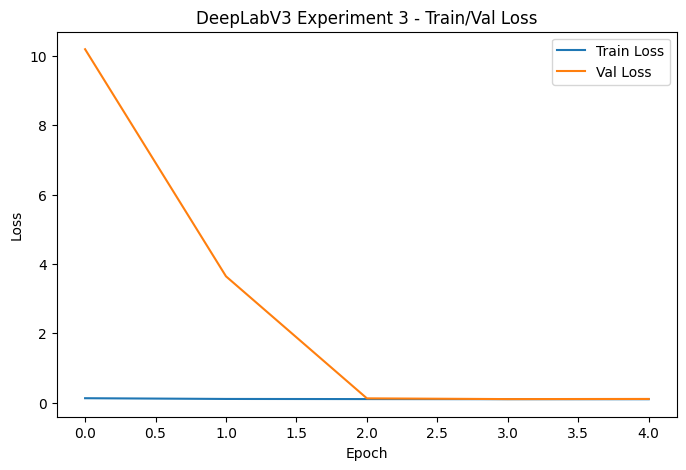

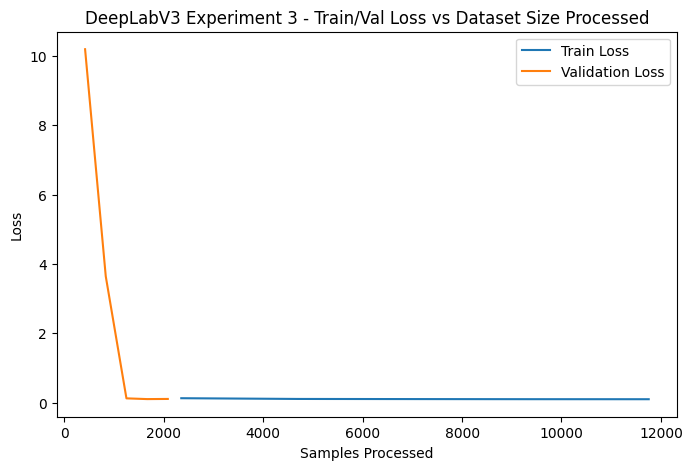

Saved model: deeplabv3_exp3_RMSprop_lr0.001_wd0.0001.pth

=== Evaluating on Test Set ===

--- Confusion Matrix for DeepLabV3 Experiment 1 ---


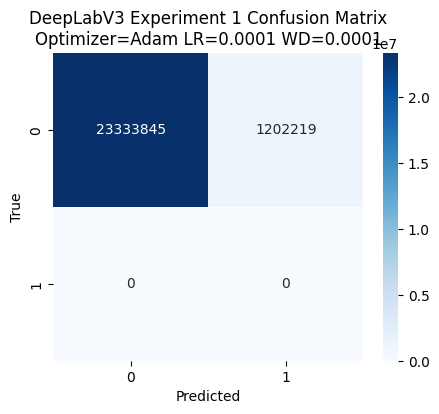


--- Confusion Matrix for DeepLabV3 Experiment 2 ---


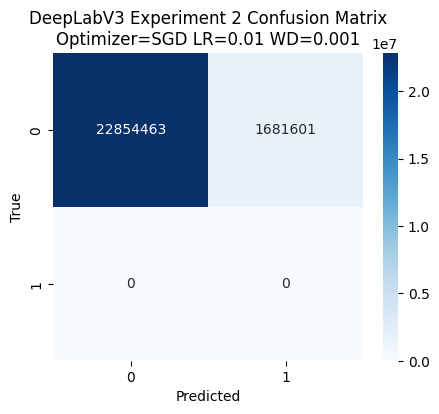


--- Confusion Matrix for DeepLabV3 Experiment 3 ---


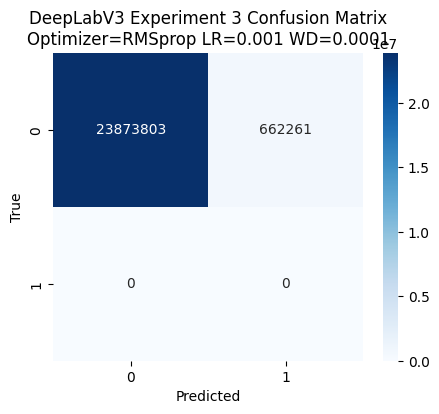

In [10]:
def get_model():
    return smp.DeepLabV3(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    ).to(device)

def get_optimizer(name, params, lr, wd):
    if name == 'Adam':
        return torch.optim.Adam(params, lr=lr, weight_decay=wd)
    elif name == 'SGD':
        return torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    elif name == 'RMSprop':
        return torch.optim.RMSprop(params, lr=lr, weight_decay=wd)
    else:
        raise ValueError(f"Unknown optimizer {name}")

deeplabv3_hyperparams = [
    {'optimizer': 'Adam',    'lr': 1e-4, 'weight_decay': 1e-4},
    {'optimizer': 'SGD',     'lr': 1e-2, 'weight_decay': 1e-3},
    {'optimizer': 'RMSprop', 'lr': 1e-3, 'weight_decay': 1e-4}
]

epochs = 5
criterion = nn.BCEWithLogitsLoss()

trained_models = []

for i, hp in enumerate(deeplabv3_hyperparams, 1):
    print(f"\n=== Training DeepLabV3 Experiment {i} with {hp} ===")
    model = get_model()
    optimizer = get_optimizer(hp['optimizer'], model.parameters(), hp['lr'], hp['weight_decay'])

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            preds = model(imgs)
            loss = criterion(preds, masks)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * imgs.size(0)
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)
                loss = criterion(preds, masks)
                total_val_loss += loss.item() * imgs.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f"DeepLabV3 Experiment {i} - Train/Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    train_data_size = len(train_ds)
    val_data_size = len(val_ds)
    epochs_range = range(1, epochs + 1)
    train_samples_processed = [epoch * train_data_size for epoch in epochs_range]
    val_samples_processed = [epoch * val_data_size for epoch in epochs_range]

    plt.figure(figsize=(8,5))
    plt.plot(train_samples_processed, train_losses, label='Train Loss')
    plt.plot(val_samples_processed, val_losses, label='Validation Loss')
    plt.xlabel('Samples Processed')
    plt.ylabel('Loss')
    plt.title(f"DeepLabV3 Experiment {i} - Train/Val Loss vs Dataset Size Processed")
    plt.legend()
    plt.show()

    # Save model
    model_path = f"deeplabv3_exp{i}_{hp['optimizer']}_lr{hp['lr']}_wd{hp['weight_decay']}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    trained_models.append((model, hp, model_path))

print("\n=== Evaluating on Test Set ===")
for i, (model, hp, model_path) in enumerate(trained_models, 1):
    print(f"\n--- Confusion Matrix for DeepLabV3 Experiment {i} ---")
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            masks = masks.numpy().astype(int)
            all_preds.append(preds.flatten())
            all_targets.append(masks.flatten())
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    cm = confusion_matrix(all_targets, all_preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"DeepLabV3 Experiment {i} Confusion Matrix\nOptimizer={hp['optimizer']} LR={hp['lr']} WD={hp['weight_decay']}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



=== Training PSPNet Experiment 1 with {'optimizer': 'Adam', 'lr': 0.01, 'weight_decay': 0.001} ===
Epoch 1/5 - Train Loss: 0.1435 - Val Loss: 0.1223
Epoch 2/5 - Train Loss: 0.1126 - Val Loss: 0.1316
Epoch 3/5 - Train Loss: 0.1126 - Val Loss: 0.1665
Epoch 4/5 - Train Loss: 0.1103 - Val Loss: 0.1769
Epoch 5/5 - Train Loss: 0.1090 - Val Loss: 0.2140


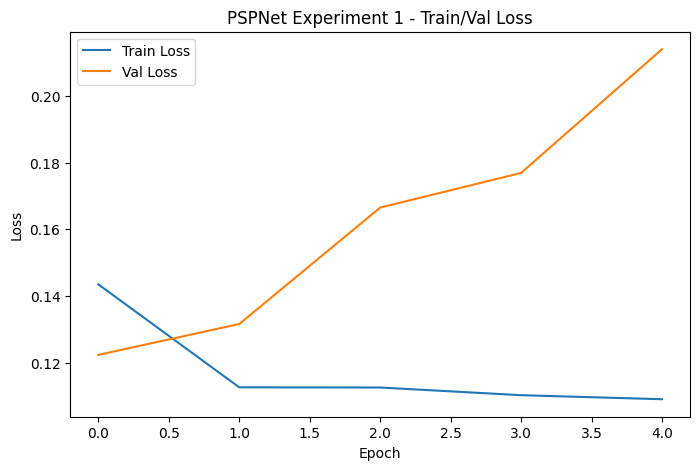

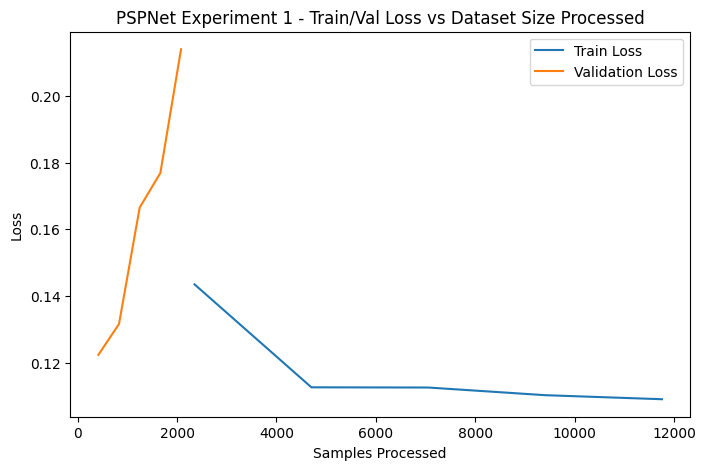

Saved model: pspnet_exp1_Adam_lr0.01_wd0.001.pth

=== Training PSPNet Experiment 2 with {'optimizer': 'SGD', 'lr': 0.0001, 'weight_decay': 0.0001} ===
Epoch 1/5 - Train Loss: 0.2331 - Val Loss: 0.1959
Epoch 2/5 - Train Loss: 0.1826 - Val Loss: 0.1763
Epoch 3/5 - Train Loss: 0.1690 - Val Loss: 0.1647
Epoch 4/5 - Train Loss: 0.1587 - Val Loss: 0.1556
Epoch 5/5 - Train Loss: 0.1514 - Val Loss: 0.1495


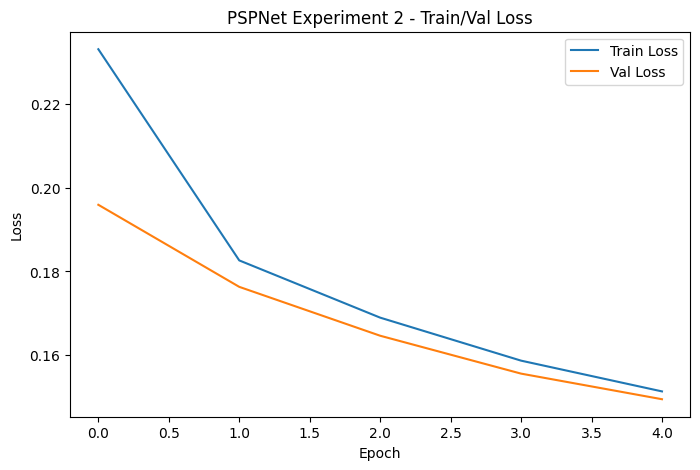

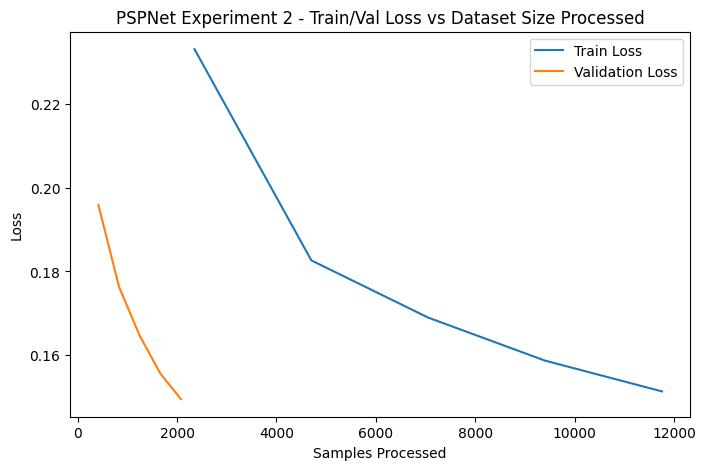

Saved model: pspnet_exp2_SGD_lr0.0001_wd0.0001.pth

=== Training PSPNet Experiment 3 with {'optimizer': 'RMSprop', 'lr': 0.001, 'weight_decay': 0} ===
Epoch 1/5 - Train Loss: 0.1192 - Val Loss: 0.1101
Epoch 2/5 - Train Loss: 0.1003 - Val Loss: 0.1025
Epoch 3/5 - Train Loss: 0.0976 - Val Loss: 0.0986
Epoch 4/5 - Train Loss: 0.0969 - Val Loss: 0.1082
Epoch 5/5 - Train Loss: 0.0952 - Val Loss: 0.0981


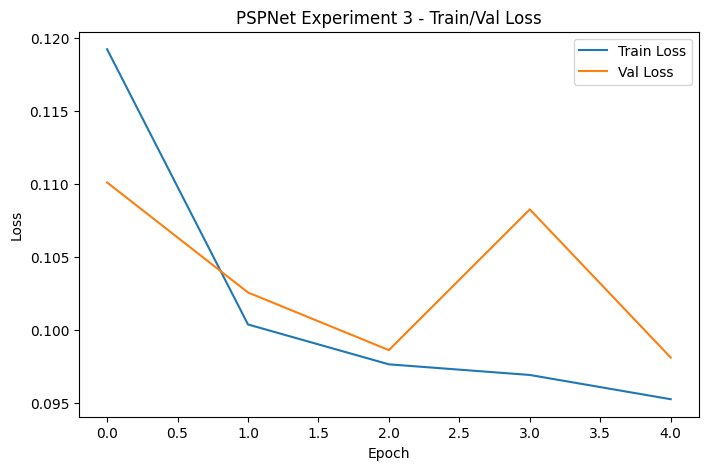

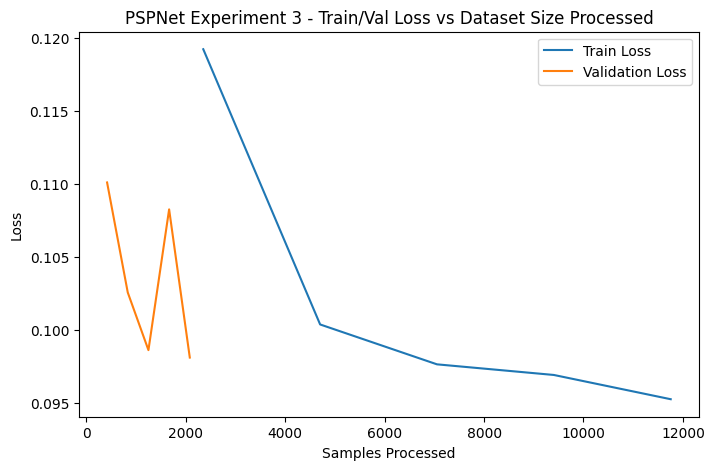

Saved model: pspnet_exp3_RMSprop_lr0.001_wd0.pth

=== Evaluating on Test Set ===

--- Confusion Matrix for PSPNet Experiment 1 ---


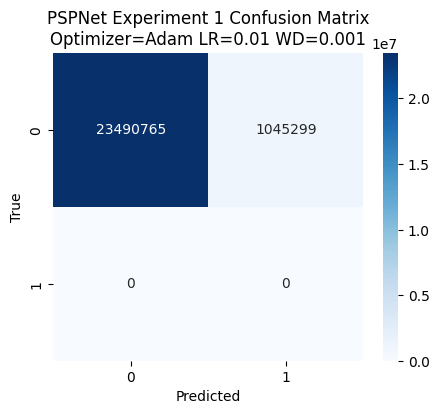


--- Confusion Matrix for PSPNet Experiment 2 ---


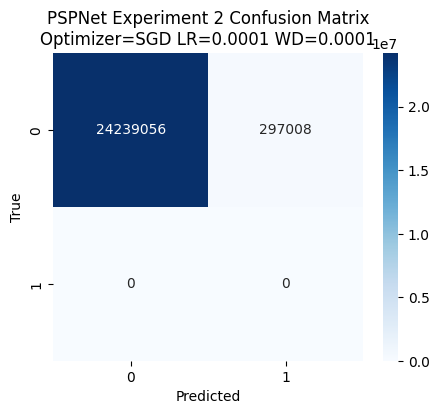


--- Confusion Matrix for PSPNet Experiment 3 ---


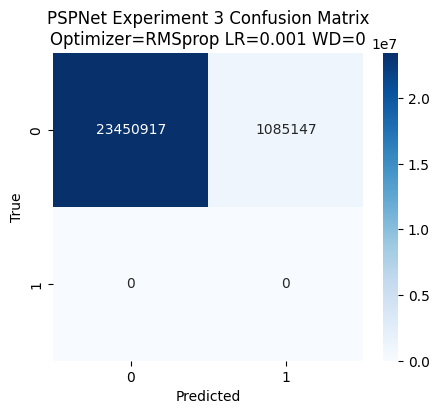

In [11]:
def get_model():
    return smp.PSPNet(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    ).to(device)

def get_optimizer(name, params, lr, wd):
    if name == 'Adam':
        return torch.optim.Adam(params, lr=lr, weight_decay=wd)
    elif name == 'SGD':
        return torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    elif name == 'RMSprop':
        return torch.optim.RMSprop(params, lr=lr, weight_decay=wd)
    else:
        raise ValueError(f"Unknown optimizer {name}")

pspnet_hyperparams = [
    {'optimizer': 'Adam',    'lr': 1e-2, 'weight_decay': 1e-3},
    {'optimizer': 'SGD',     'lr': 1e-4, 'weight_decay': 1e-4},
    {'optimizer': 'RMSprop', 'lr': 1e-3, 'weight_decay': 0}
]

epochs = 5
criterion = nn.BCEWithLogitsLoss()

trained_models = []

for i, hp in enumerate(pspnet_hyperparams, 1):
    print(f"\n=== Training PSPNet Experiment {i} with {hp} ===")
    model = get_model()
    optimizer = get_optimizer(hp['optimizer'], model.parameters(), hp['lr'], hp['weight_decay'])

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            preds = model(imgs)
            loss = criterion(preds, masks)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * imgs.size(0)
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)
                loss = criterion(preds, masks)
                total_val_loss += loss.item() * imgs.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f"PSPNet Experiment {i} - Train/Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot Train/Validation Loss vs Dataset Size Processed
    train_data_size = len(train_ds)
    val_data_size = len(val_ds)
    epochs_range = range(1, epochs + 1)
    train_samples_processed = [epoch * train_data_size for epoch in epochs_range]
    val_samples_processed = [epoch * val_data_size for epoch in epochs_range]

    plt.figure(figsize=(8,5))
    plt.plot(train_samples_processed, train_losses, label='Train Loss')
    plt.plot(val_samples_processed, val_losses, label='Validation Loss')
    plt.xlabel('Samples Processed')
    plt.ylabel('Loss')
    plt.title(f"PSPNet Experiment {i} - Train/Val Loss vs Dataset Size Processed")
    plt.legend()
    plt.show()

    # Save model
    model_path = f"pspnet_exp{i}_{hp['optimizer']}_lr{hp['lr']}_wd{hp['weight_decay']}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    trained_models.append((model, hp, model_path))

print("\n=== Evaluating on Test Set ===")
for i, (model, hp, model_path) in enumerate(trained_models, 1):
    print(f"\n--- Confusion Matrix for PSPNet Experiment {i} ---")
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            masks = masks.numpy().astype(int)
            all_preds.append(preds.flatten())
            all_targets.append(masks.flatten())
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    cm = confusion_matrix(all_targets, all_preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"PSPNet Experiment {i} Confusion Matrix\nOptimizer={hp['optimizer']} LR={hp['lr']} WD={hp['weight_decay']}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


=== UNet_Adam (/kaggle/working/unet_exp1_Adam_lr0.001_wd0.0001.pth) ===
  Sample 1:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8903, IoU=0.8022, Pixel Acc=0.9752


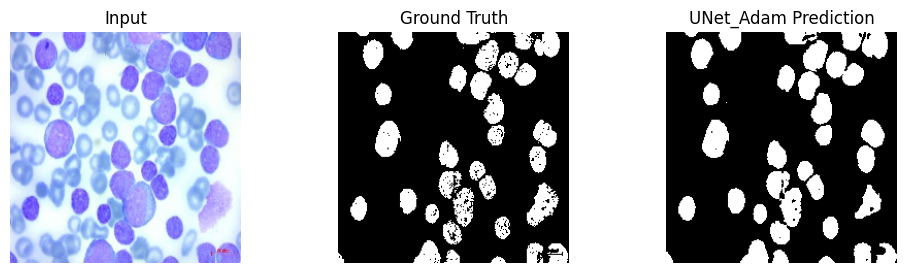

  Sample 2:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8834, IoU=0.7911, Pixel Acc=0.9835


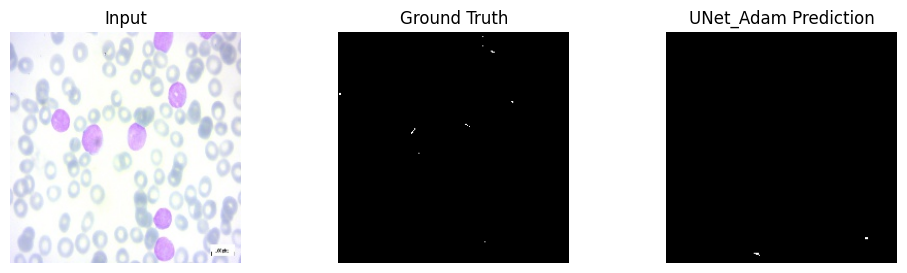

  Sample 3:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.9022, IoU=0.8219, Pixel Acc=0.9828


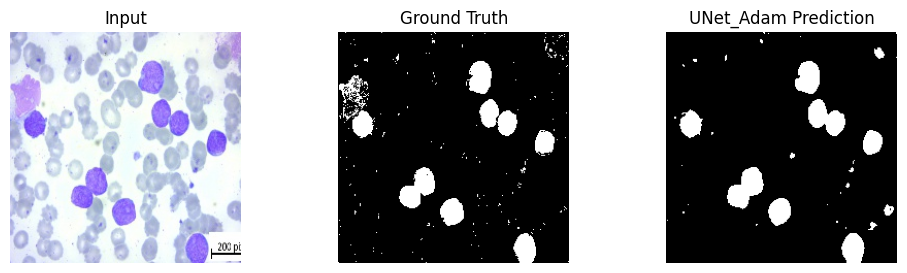


=== UNet_SGD (/kaggle/working/unet_exp2_SGD_lr0.01_wd0.001.pth) ===
  Sample 1:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8983, IoU=0.8154, Pixel Acc=0.9758


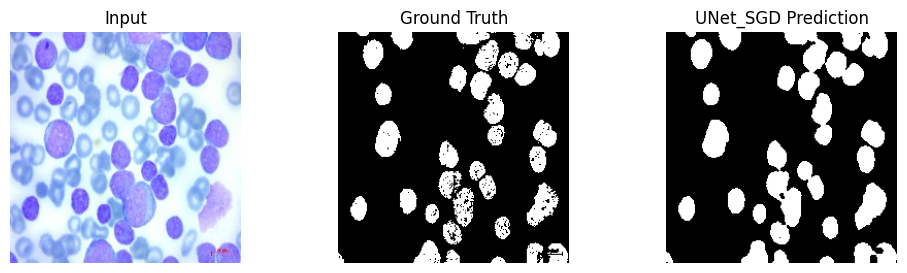

  Sample 2:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8955, IoU=0.8108, Pixel Acc=0.9843


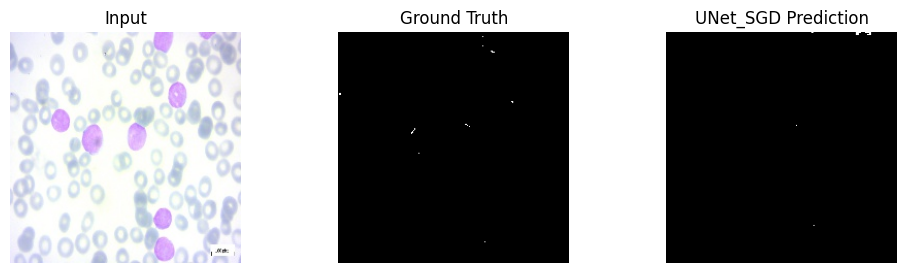

  Sample 3:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.9153, IoU=0.8437, Pixel Acc=0.9841


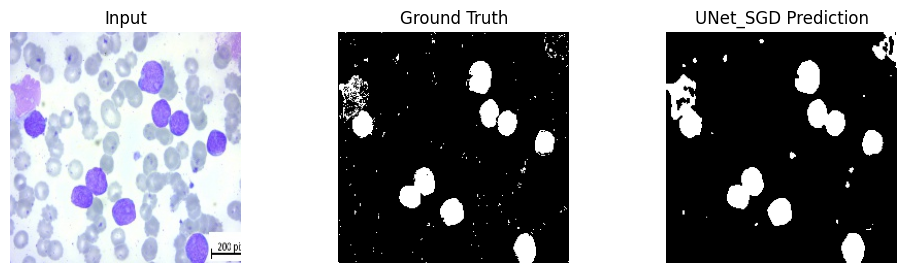


=== UNet_RMSprop (/kaggle/working/unet_exp3_RMSprop_lr0.0001_wd0.pth) ===
  Sample 1:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.9039, IoU=0.8247, Pixel Acc=0.9770


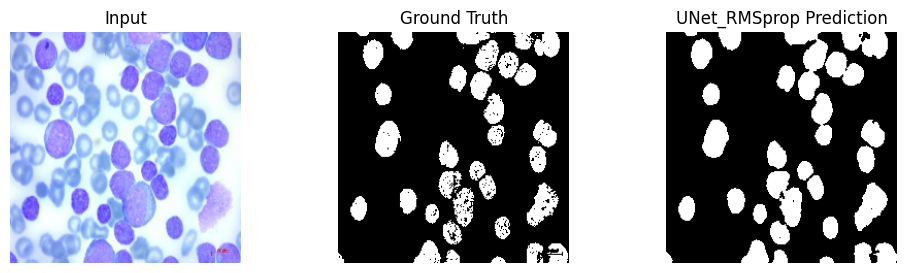

  Sample 2:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.9060, IoU=0.8282, Pixel Acc=0.9859


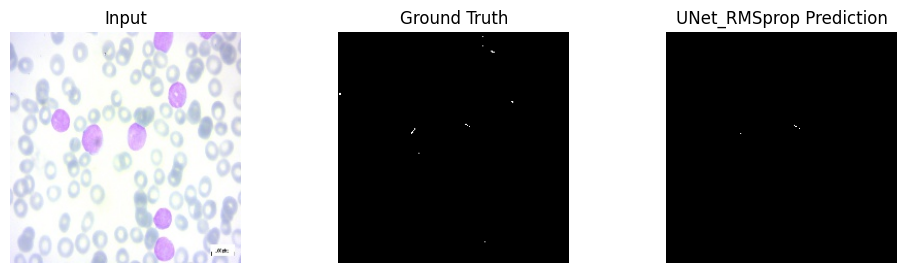

  Sample 3:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.9240, IoU=0.8587, Pixel Acc=0.9858


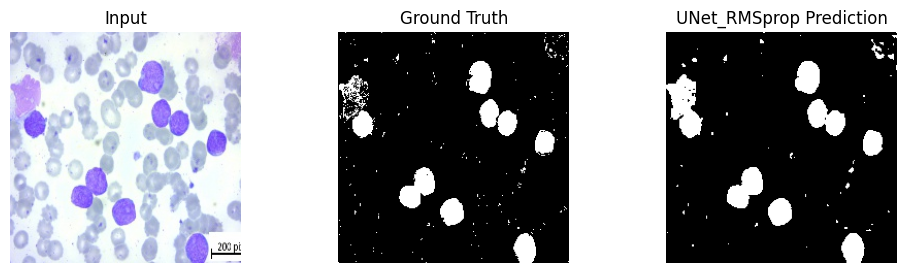


=== FPN_Adam (/kaggle/working/fpn_exp1_Adam_lr0.01_wd0.001.pth) ===
  Sample 1:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8077, IoU=0.6775, Pixel Acc=0.9493


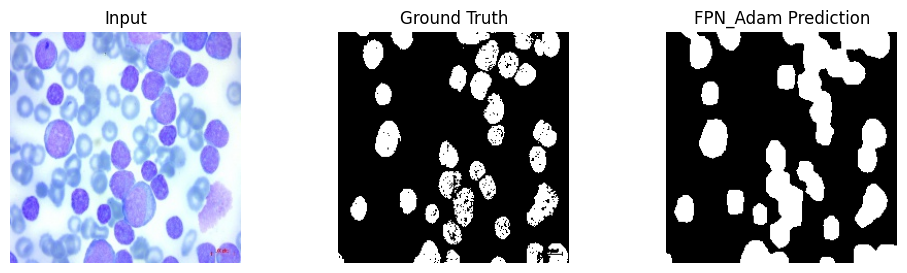

  Sample 2:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8282, IoU=0.7067, Pixel Acc=0.9726


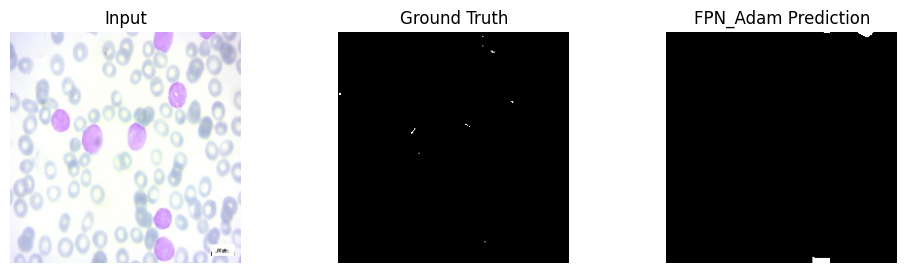

  Sample 3:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8252, IoU=0.7025, Pixel Acc=0.9640


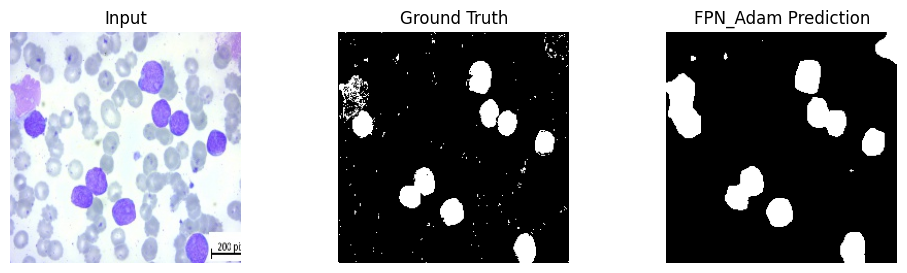


=== FPN_SGD (/kaggle/working/fpn_exp2_SGD_lr0.001_wd0.0001.pth) ===
  Sample 1:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8065, IoU=0.6757, Pixel Acc=0.9523


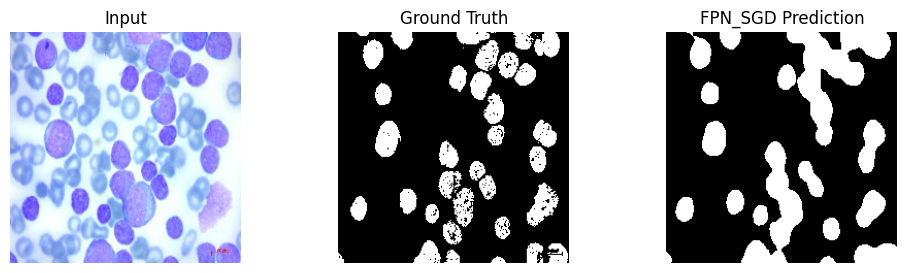

  Sample 2:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8267, IoU=0.7046, Pixel Acc=0.9742


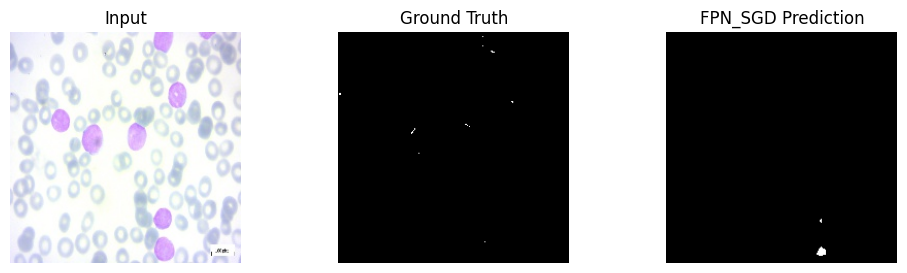

  Sample 3:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8267, IoU=0.7046, Pixel Acc=0.9669


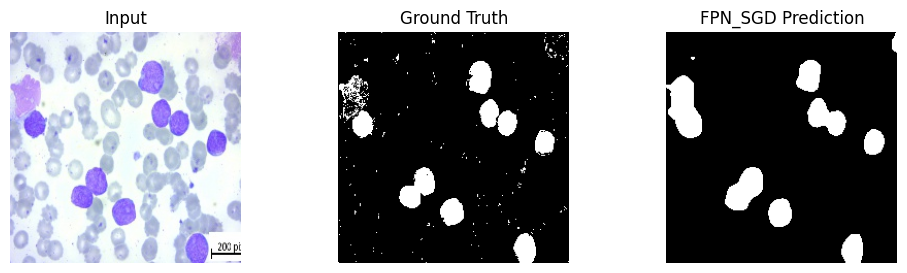


=== FPN_RMSprop (/kaggle/working/fpn_exp3_RMSprop_lr0.0001_wd0.pth) ===
  Sample 1:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8655, IoU=0.7629, Pixel Acc=0.9666


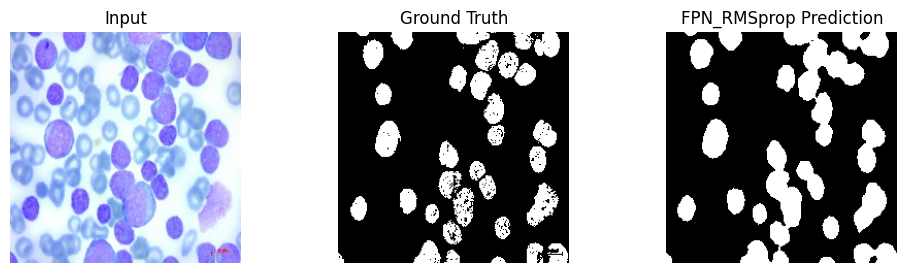

  Sample 2:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8743, IoU=0.7766, Pixel Acc=0.9807


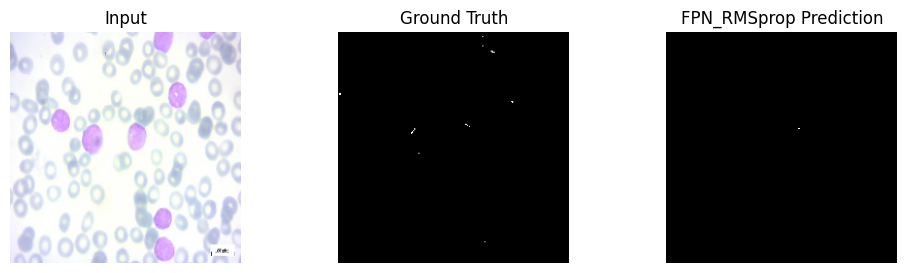

  Sample 3:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8757, IoU=0.7789, Pixel Acc=0.9755


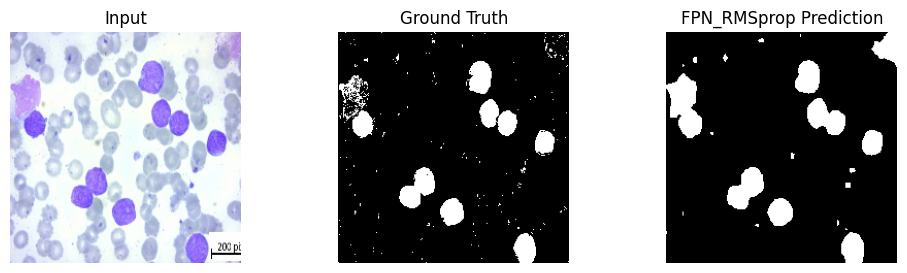


=== PSPNet_Adam (/kaggle/working/pspnet_exp1_Adam_lr0.01_wd0.001.pth) ===
  Sample 1:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.4593, IoU=0.2981, Pixel Acc=0.7519


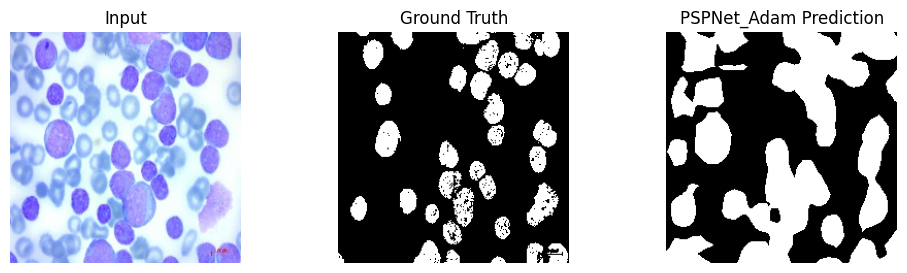

  Sample 2:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.3274, IoU=0.1957, Pixel Acc=0.7263


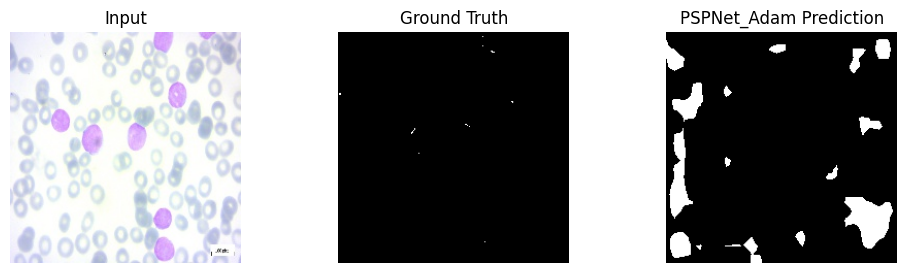

  Sample 3:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.4429, IoU=0.2844, Pixel Acc=0.8022


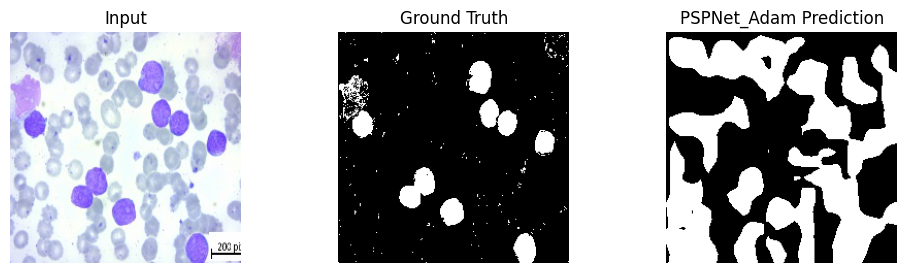


=== PSPNet_SGD (/kaggle/working/pspnet_exp2_SGD_lr0.0001_wd0.0001.pth) ===
  Sample 1:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.6737, IoU=0.5080, Pixel Acc=0.9248


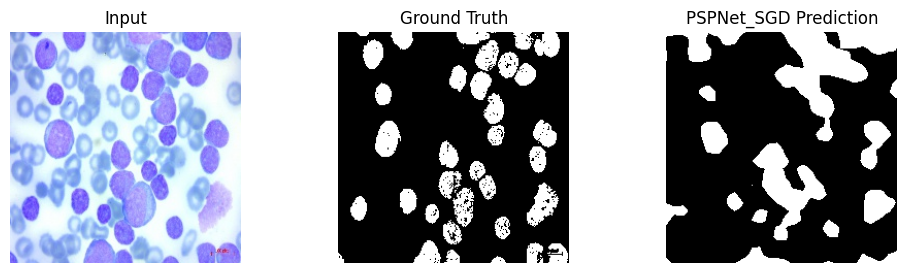

  Sample 2:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.6566, IoU=0.4888, Pixel Acc=0.9523


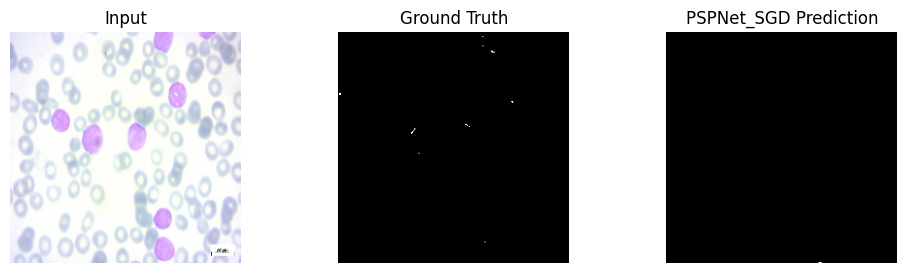

  Sample 3:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.6481, IoU=0.4794, Pixel Acc=0.9432


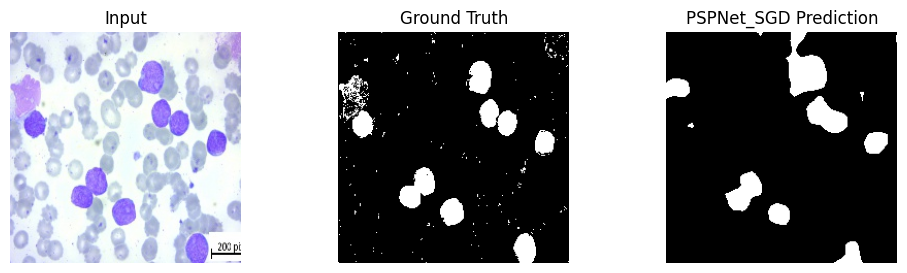


=== PSPNet_RMSprop (/kaggle/working/pspnet_exp3_RMSprop_lr0.001_wd0.pth) ===
  Sample 1:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8591, IoU=0.7530, Pixel Acc=0.9661


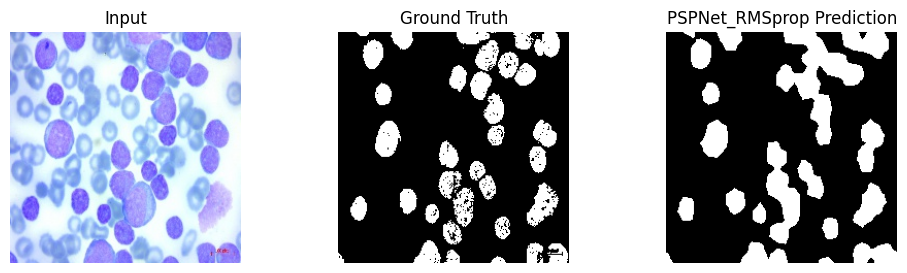

  Sample 2:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8702, IoU=0.7703, Pixel Acc=0.9807


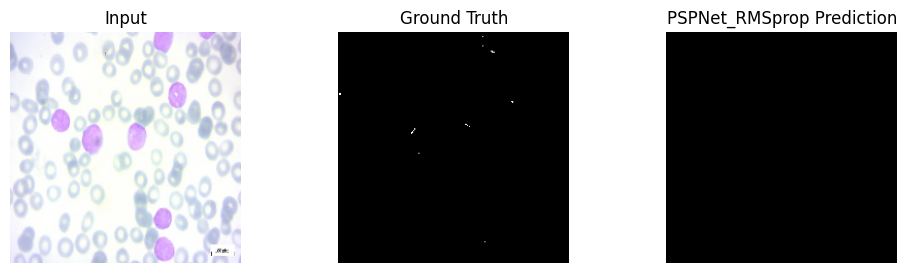

  Sample 3:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8762, IoU=0.7796, Pixel Acc=0.9765


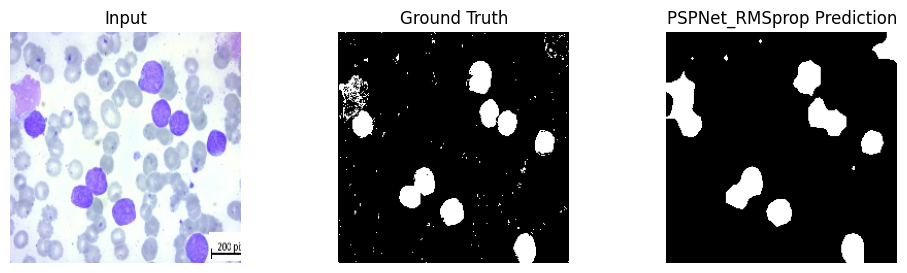


=== DeepLabV3_Adam (/kaggle/working/deeplabv3_exp1_Adam_lr0.0001_wd0.0001.pth) ===
  Sample 1:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8507, IoU=0.7402, Pixel Acc=0.9637


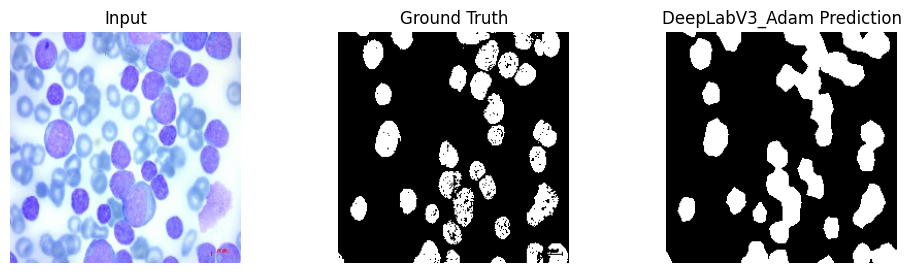

  Sample 2:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8574, IoU=0.7504, Pixel Acc=0.9785


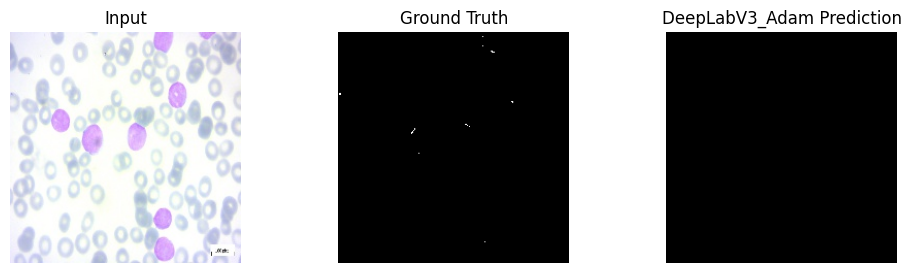

  Sample 3:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8705, IoU=0.7707, Pixel Acc=0.9754


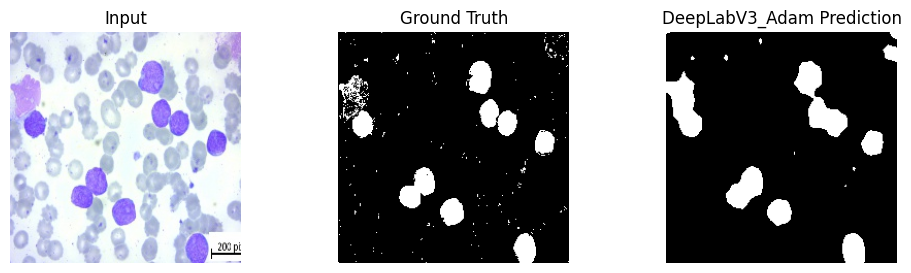


=== DeepLabV3_SGD (/kaggle/working/deeplabv3_exp2_SGD_lr0.01_wd0.001.pth) ===
  Sample 1:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.7627, IoU=0.6164, Pixel Acc=0.9330


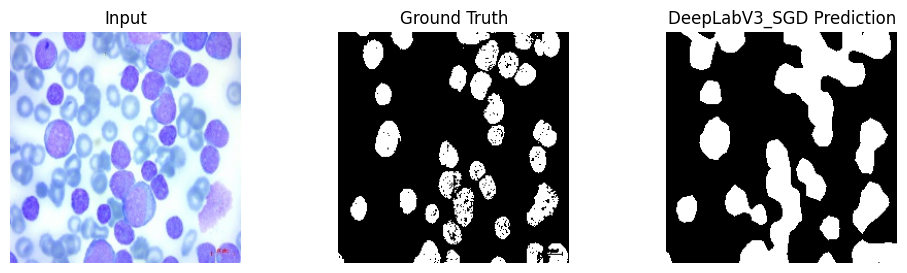

  Sample 2:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.7590, IoU=0.6115, Pixel Acc=0.9573


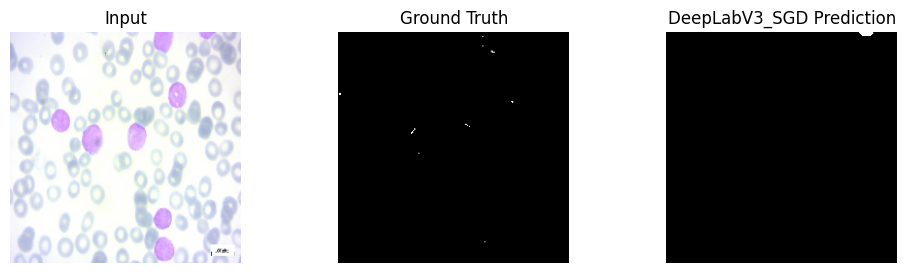

  Sample 3:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.7607, IoU=0.6138, Pixel Acc=0.9460


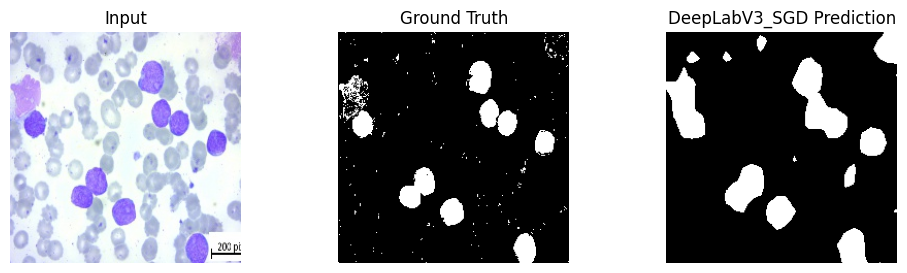


=== DeepLabV3_RMSprop (/kaggle/working/deeplabv3_exp3_RMSprop_lr0.001_wd0.0001.pth) ===
  Sample 1:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8317, IoU=0.7118, Pixel Acc=0.9641


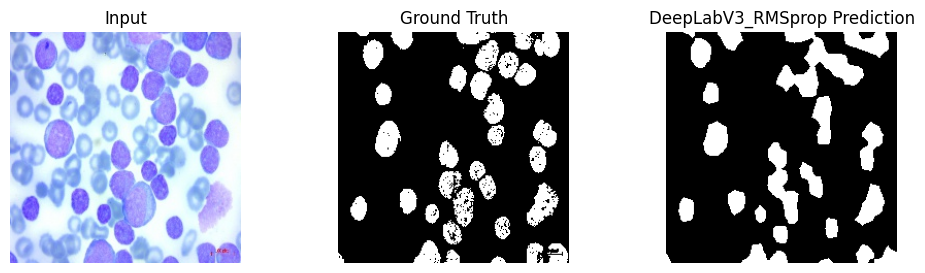

  Sample 2:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8440, IoU=0.7302, Pixel Acc=0.9792


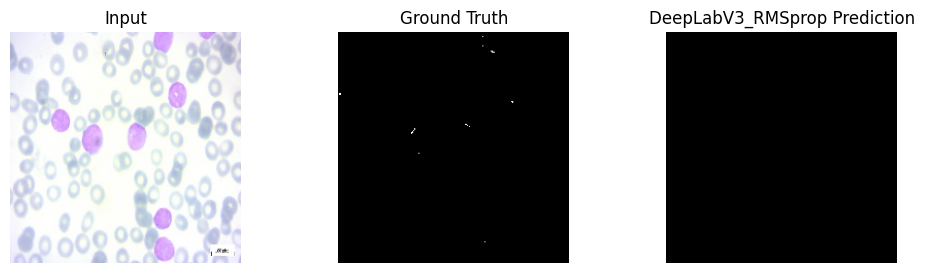

  Sample 3:
    Unique values in GT mask: [0 1]
    Unique values in prediction: [0 1]
    Dice=0.8572, IoU=0.7500, Pixel Acc=0.9753


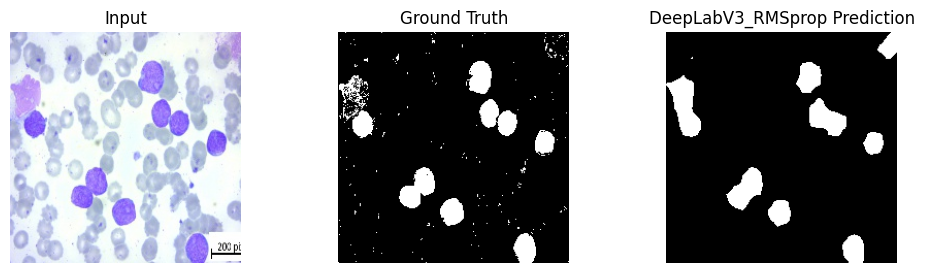

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def dice_coef(pred, target, epsilon=1e-6):
    pred = pred.flatten()
    target = target.flatten()
    intersection = np.sum(pred * target)
    return (2. * intersection + epsilon) / (np.sum(pred) + np.sum(target) + epsilon)

def iou_coef(pred, target, epsilon=1e-6):
    pred = pred.flatten()
    target = target.flatten()
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target) - intersection
    return (intersection + epsilon) / (union + epsilon)

def pixel_acc(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    return np.sum(pred == target) / len(pred)

def get_unet():
    return smp.Unet(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    ).to(device)

def get_fpn():
    return smp.FPN(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    ).to(device)

def get_pspnet():
    return smp.PSPNet(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    ).to(device)

def get_deeplabv3():
    return smp.DeepLabV3(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    ).to(device)
    

# --- List of model info: (pretty name, model function, path) ---
all_model_files = [
    ("UNet_Adam",      get_unet,      "/kaggle/working/unet_exp1_Adam_lr0.001_wd0.0001.pth"),
    ("UNet_SGD",       get_unet,      "/kaggle/working/unet_exp2_SGD_lr0.01_wd0.001.pth"),
    ("UNet_RMSprop",   get_unet,      "/kaggle/working/unet_exp3_RMSprop_lr0.0001_wd0.pth"),
    ("FPN_Adam",       get_fpn,       "/kaggle/working/fpn_exp1_Adam_lr0.01_wd0.001.pth"),
    ("FPN_SGD",        get_fpn,       "/kaggle/working/fpn_exp2_SGD_lr0.001_wd0.0001.pth"),
    ("FPN_RMSprop",    get_fpn,       "/kaggle/working/fpn_exp3_RMSprop_lr0.0001_wd0.pth"),
    ("PSPNet_Adam",    get_pspnet,    "/kaggle/working/pspnet_exp1_Adam_lr0.01_wd0.001.pth"),
    ("PSPNet_SGD",     get_pspnet,    "/kaggle/working/pspnet_exp2_SGD_lr0.0001_wd0.0001.pth"),
    ("PSPNet_RMSprop", get_pspnet,    "/kaggle/working/pspnet_exp3_RMSprop_lr0.001_wd0.pth"),
    ("DeepLabV3_Adam", get_deeplabv3, "/kaggle/working/deeplabv3_exp1_Adam_lr0.0001_wd0.0001.pth"),
    ("DeepLabV3_SGD",  get_deeplabv3, "/kaggle/working/deeplabv3_exp2_SGD_lr0.01_wd0.001.pth"),
    ("DeepLabV3_RMSprop", get_deeplabv3, "/kaggle/working/deeplabv3_exp3_RMSprop_lr0.001_wd0.0001.pth"),
]

test_iter = iter(test_loader)
test_samples = []
for _ in range(3):
    try:
        test_samples.append(next(test_iter))
    except StopIteration:
        break

def show_img(img, title="Image"):
    img = np.array(img)
    if img.ndim == 4:
        img = img[0]
    if img.ndim == 3:
        if img.shape[0] == 1:
            img = img[0]
        elif img.shape[0] == 3:
            img = np.transpose(img, (1,2,0))
    plt.imshow(img, cmap='gray' if img.ndim==2 or (img.ndim==3 and img.shape[-1]==1) else None)
    plt.title(title)
    plt.axis('off')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for model_name, get_model_fn, weight_path in all_model_files:
    model = get_model_fn()
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.to(device)
    model.eval()

    print(f"\n=== {model_name} ({weight_path}) ===")
    for idx, (img, mask) in enumerate(test_samples):
        img = img.to(device)
        mask = mask.to(device)
        # ---- Force binary mask ----
        mask_bin = (mask > 0.5).float()
        with torch.no_grad():
            pred = model(img)
            pred = torch.sigmoid(pred)
            pred = (pred > 0.2).float()   # Lower threshold!
        pred_np = pred.cpu().numpy().astype(np.uint8)
        mask_np = mask_bin.cpu().numpy().astype(np.uint8)

        print(f"  Sample {idx+1}:")
        print("    Unique values in GT mask:", np.unique(mask_np))
        print("    Unique values in prediction:", np.unique(pred_np))

        dice = dice_coef(pred_np, mask_np)
        iou = iou_coef(pred_np, mask_np)
        acc = pixel_acc(pred_np, mask_np)
        print(f"    Dice={dice:.4f}, IoU={iou:.4f}, Pixel Acc={acc:.4f}")
        
        plt.figure(figsize=(12,3))
        plt.subplot(1,3,1)
        show_img(img.cpu().numpy(), "Input")
        plt.subplot(1,3,2)
        show_img(mask_np, "Ground Truth")
        plt.subplot(1,3,3)
        show_img(pred_np, f"{model_name} Prediction")
        plt.show()

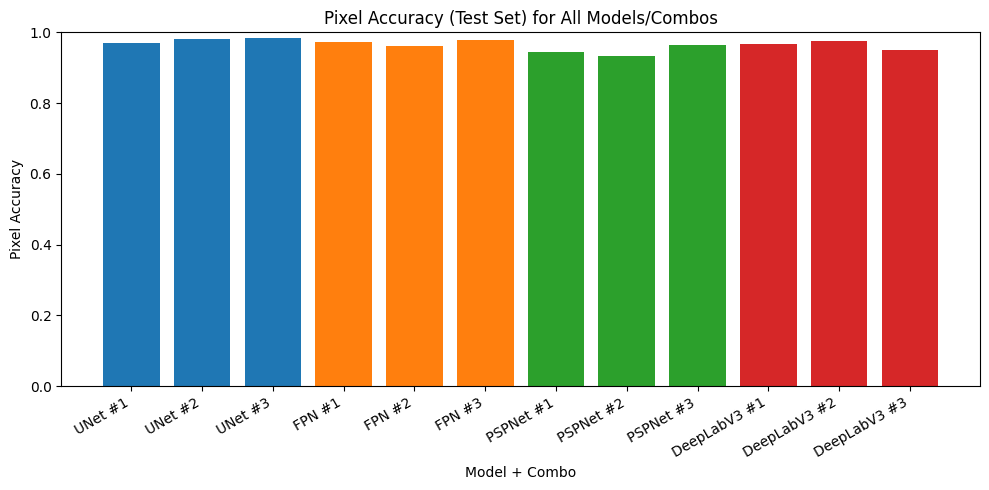

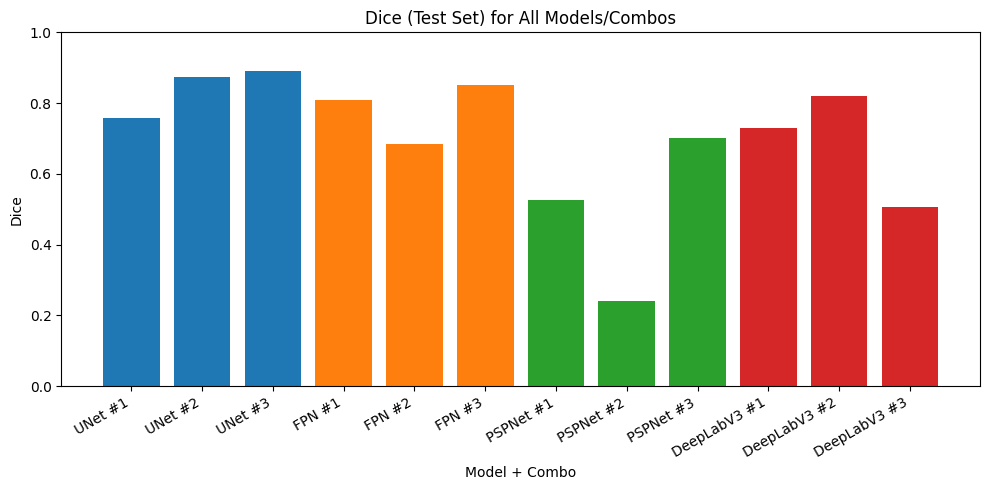

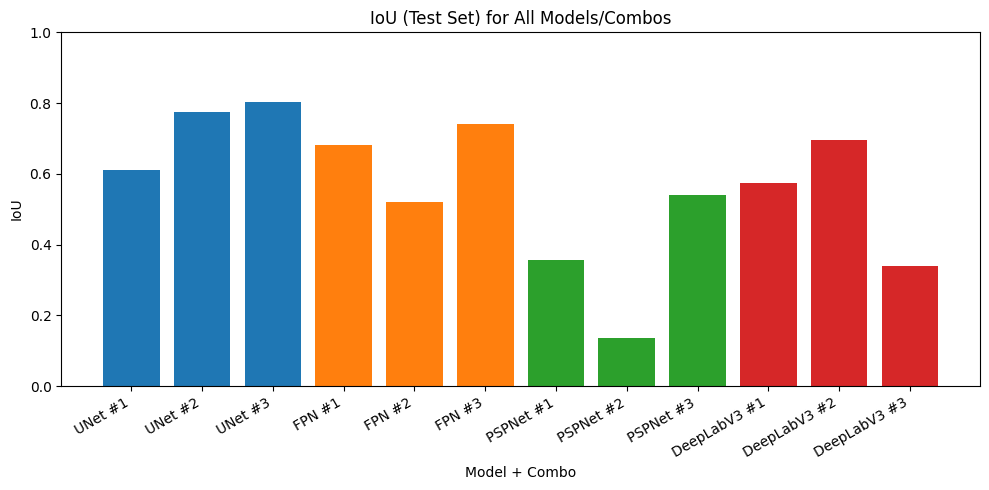

        Model  Combo Optimizer      LR  Weight Decay  Pixel Accuracy  \
0        UNet      1      Adam  0.0010        0.0001        0.969960   
1        UNet      2       SGD  0.0100        0.0010        0.982437   
2        UNet      3   RMSprop  0.0001        0.0000        0.984653   
3         FPN      1      Adam  0.0100        0.0010        0.973016   
4         FPN      2       SGD  0.0010        0.0001        0.961365   
5         FPN      3   RMSprop  0.0001        0.0000        0.979426   
6      PSPNet      1      Adam  0.0100        0.0010        0.944010   
7      PSPNet      2       SGD  0.0001        0.0001        0.933453   
8      PSPNet      3   RMSprop  0.0010        0.0000        0.964122   
9   DeepLabV3      1      Adam  0.0001        0.0001        0.966278   
10  DeepLabV3      2       SGD  0.0100        0.0010        0.974101   
11  DeepLabV3      3   RMSprop  0.0010        0.0001        0.949378   

        Dice       IoU  
0   0.758961  0.611552  
1   0.873390 

In [25]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_to_train = {
    'unet': 'UNet',
    'fpn': 'FPN',
    'pspnet': 'PSPNet',
    'deeplabv3': 'DeepLabV3'
}

model_hyperparams = {
    'unet': [
        {'optimizer': 'Adam',    'lr': 1e-3, 'weight_decay': 1e-4},
        {'optimizer': 'SGD',     'lr': 1e-2, 'weight_decay': 1e-3},
        {'optimizer': 'RMSprop', 'lr': 1e-4, 'weight_decay': 0}
    ],
    'fpn': [
        {'optimizer': 'Adam',    'lr': 1e-2, 'weight_decay': 1e-3},
        {'optimizer': 'SGD',     'lr': 1e-3, 'weight_decay': 1e-4},
        {'optimizer': 'RMSprop', 'lr': 1e-4, 'weight_decay': 0}
    ],
    'pspnet': [
        {'optimizer': 'Adam',    'lr': 1e-2, 'weight_decay': 1e-3},
        {'optimizer': 'SGD',     'lr': 1e-4, 'weight_decay': 1e-4},
        {'optimizer': 'RMSprop', 'lr': 1e-3, 'weight_decay': 0}
    ],
    'deeplabv3': [
        {'optimizer': 'Adam',    'lr': 1e-4, 'weight_decay': 1e-4},
        {'optimizer': 'SGD',     'lr': 1e-2, 'weight_decay': 1e-3},
        {'optimizer': 'RMSprop', 'lr': 1e-3, 'weight_decay': 1e-4}
    ]
}

def get_model(arch_key):
    model_map = {
        'unet': smp.Unet,
        'fpn': smp.FPN,
        'pspnet': smp.PSPNet,
        'deeplabv3': smp.DeepLabV3
    }
    return model_map[arch_key](encoder_name="resnet50", encoder_weights=None,
                                in_channels=3, classes=1, activation=None).to(device)

def compute_dice_iou_acc(model, dataloader, threshold=0.5):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            preds = model(images)
            preds = torch.sigmoid(preds).cpu().numpy() > threshold
            masks = masks.cpu().numpy() > threshold
            all_preds.append(preds.flatten())
            all_targets.append(masks.flatten())
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)
    intersection = np.logical_and(y_pred, y_true).sum()
    dice = (2. * intersection) / (y_pred.sum() + y_true.sum() + 1e-8)
    union = np.logical_or(y_pred, y_true).sum()
    iou = intersection / (union + 1e-8)
    pixel_acc = (y_pred == y_true).mean()
    return pixel_acc, dice, iou

results = []
for arch_key, model_label in models_to_train.items():
    for idx, hp in enumerate(model_hyperparams[arch_key]):
        fname = f"/kaggle/working/{arch_key}_exp{idx+1}_{hp['optimizer']}_lr{hp['lr']}_wd{hp['weight_decay']}.pth"
        if not os.path.exists(fname):
            print(f" File not found: {fname}")
            continue
        model = get_model(arch_key)
        model.load_state_dict(torch.load(fname, map_location=device))
        pixel_acc, dice, iou = compute_dice_iou_acc(model, test_loader)
        results.append({
            "Model": model_label,
            "Combo": idx+1,
            "Optimizer": hp['optimizer'],
            "LR": hp['lr'],
            "Weight Decay": hp['weight_decay'],
            "Pixel Accuracy": pixel_acc,
            "Dice": dice,
            "IoU": iou
        })


df = pd.DataFrame(results)

metrics = ["Pixel Accuracy", "Dice", "IoU"]
for metric in metrics:
    plt.figure(figsize=(10, 5))
    for model_label in df['Model'].unique():
        subset = df[df['Model'] == model_label]
        plt.bar(
            [f"{model_label} #{row.Combo}" for _, row in subset.iterrows()],
            subset[metric], label=model_label
        )
    plt.title(f"{metric} (Test Set) for All Models/Combos")
    plt.ylabel(metric)
    plt.xlabel("Model + Combo")
    plt.xticks(rotation=30, ha='right')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

print(df[["Model", "Combo", "Optimizer", "LR", "Weight Decay", "Pixel Accuracy", "Dice", "IoU"]])
